In [1]:
import numpy.random as random
import numpy as np
import sys
from scipy import signal
from scipy.special import j0
from scipy.special import j1
from scipy.special import jn_zeros
import matplotlib.cm as cm
from matplotlib import pyplot as plt

# Model: calculation of phase velocity and group velocity

$p = \tanh((f-f_0)*20)*0.06+0.33$

$C_p = 1/p$

$C_g = 1/(f*0.06*20/\cosh^2((f-f_0)*20))+p)$

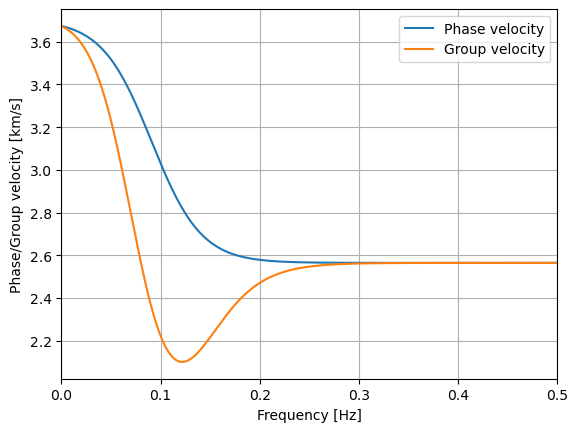

In [14]:
def cal_disp(freq):
    freq0 = 0.1
    p = np.tanh((freq-freq0)*20)*0.06+0.33
    return 1./p, 1/(freq*0.06*20/(np.cosh((freq-freq0)*20))**2+p)

Δt = 1.
length = 1024
freq0 = 0.1
Δf = 1./(length*Δt)
t_ary = np.arange(0,length)
f_ary = np.arange(length//2+1)*Δf
ω_ary = f_ary*2*np.pi

cp,cg = np.array([cal_disp(freq) for freq in f_ary]).T
k = 2*np.pi*f_ary/cp

plt.plot(f_ary,cp,label="Phase velocity")
plt.plot(f_ary,cg,label="Group velocity")
plt.grid()
plt.xlim(0,0.5)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase/Group velocity [km/s]")
plt.legend()

# FTAN diagram

## (1) Plot Gaussian filters

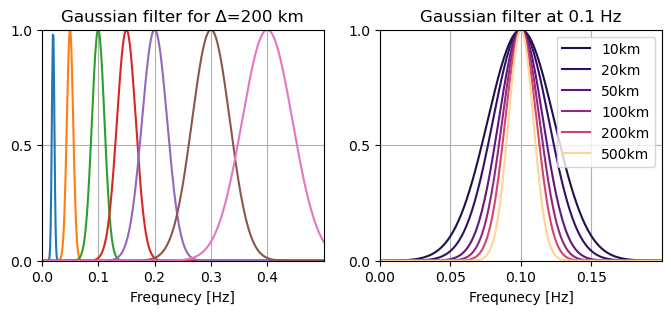

In [48]:
freq0 = 0.1
cp,cg = np.array([cal_disp(freq) for freq in f_ary]).T
k = 2*np.pi*f_ary/cp
Δt = 1.
fig, axes = plt.subplots(1,2,figsize=(8,3))

#Plot an FTAN diagram for Δ=200 km
Δ = 200
α = 40.0*np.sqrt(Δ/200.)
for freq in [0.02,0.05,0.1,0.15,0.2,0.3,0.4]:
    filt = np.exp(-α*((f_ary-freq)/freq)**2)
    sgram = np.fft.irfft((j0(k*Δ)+np.random.randn(len(k))*3E-2)*filt)
    axes[0].plot(f_ary,filt) #Plot a Gaussian filter

axes[0].set_title("Gaussian filter for Δ=200 km")
axes[0].set_ylim(0,1)
axes[0].set_xlim(0,0.5)
axes[0].set_xticks(np.arange(0,0.5,0.1))
axes[0].set_yticks([0,0.5,1])
axes[0].set_xlabel("Frequnecy [Hz]")
axes[0].grid()

for Δ in [10,20,50,100,200,500] :
    α = 40.0*np.sqrt(Δ/200.)
    filt = np.exp(-α*((f_ary-0.1)/0.1)**2)
    cbmap = axes[1].plot(f_ary,filt,color=cm.magma(np.sqrt(Δ/600)),label=str(Δ)+"km")
axes[1].set_title("Gaussian filter at 0.1 Hz")
axes[1].set_ylim(0,1)
axes[1].set_xlim(0,0.2)
axes[1].set_xticks(np.arange(0,0.2,0.05))
axes[1].set_yticks([0,0.5,1])
axes[1].set_xlabel("Frequnecy [Hz]")
axes[1].legend()
axes[1].grid()
plt.show()


## (2) Synthetic seismograms

$J_0(k(\omega)\Delta)+n(\omega)$

Standard deviation of noise $n$ is 0.01

Text(0.5, 0, 'Frequency [Hz]')

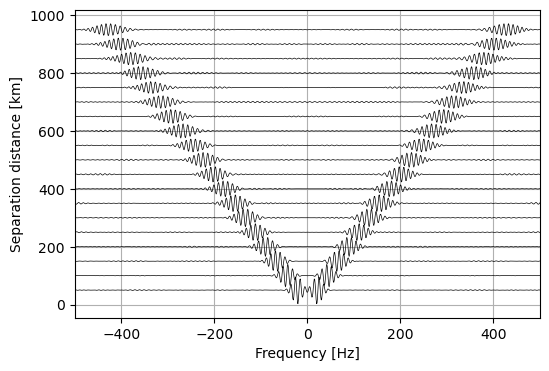

In [101]:
f_measure = 0.1
plt.figure(figsize=(6,4))
sgrams_all = np.zeros((length,len(np.arange(50,1000,50))))
for i, Δ in enumerate(np.arange(50,1000,50)):
    α = 40.0*np.sqrt(Δ/200.)
    filt = np.exp(-α*((f_ary-f_measure)/f_measure)**2)
    #Signal J0(kΔ), Noise 1%
    sgram = np.fft.fftshift(np.fft.irfft((j0(k*Δ)+np.random.randn(len(k))*1E-2)*filt))
    sgrams_all[:,i] = sgram[:]*np.sqrt(Δ)
    plt.plot(np.arange(-512,512,1),sgram*7E2*np.sqrt(Δ)+Δ,color="k",linewidth=0.5)
plt.xlim(-500,500)
plt.grid()
plt.ylabel("Separation distance [km]")
plt.xlabel("Frequency [Hz]")

## (3) Plot a FTAN diagram

/var/folders/10/39tm3b6s437bhjqhp63t577w0000gn/T/ipykernel_61086/285885575.py:15: RuntimeWarning: divide by zero encountered in divide
  Cg_ary = Δ/t_ary


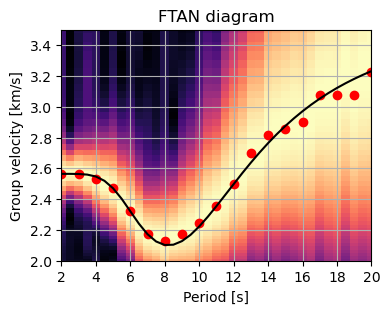

In [41]:
plt.figure(figsize=(4,3))
FTAN = np.zeros((len(t_ary),200))
Cg_obs = np.zeros(200)
Cg_syn = np.zeros(200)
for iperiod in range(2,200):
    period = iperiod/2.
    freq = 1./period
    filt = np.exp(-α*((f_ary-freq)/freq)**2)
    sgram = np.fft.irfft((j0(k*Δ)+np.random.randn(len(k))*3E-2)*filt)
    anl = signal.hilbert(sgram) #*np.exp(-1j*2*np.pi*freq0*Δ/3)
    env = abs(anl)
    FTAN[:,iperiod] = env/max(env)
    Cg_obs[iperiod] = Δ/(np.argmax(env[5:200])+5.)
    Cg_syn[iperiod] = cal_disp(1/period)[1]
Cg_ary = Δ/t_ary
Cg_ary[0] = 1E3
period_ary = np.arange(200)*0.5
plt.pcolormesh(period_ary,Cg_ary,FTAN,cmap=cm.magma, rasterized=True)
plt.plot(np.arange(100),Cg_obs[::2],"o",color="red")
plt.plot(np.arange(200)/2.,Cg_syn,color="k")

plt.title("FTAN diagram")
plt.ylabel("Group velocity [km/s]")
plt.xlabel("Period [s]")
plt.ylim(2,3.5)
plt.xlim(2,20)
plt.xticks((2,4,6,8,10,12,14,16,18,20))
plt.grid()
plt.show()

# Group and phase velocity measurements

## (1) Group velocity measurements

Data processings
* Calculate the analytical signal $\Phi^d(t)$ using Hilbert transform.
* $\Phi^d(t) = env(t) e^{i\phi^d(t)}$, where $env(t)$ is envelope, and $\phi^d(t)$ is the instanteneous phase.
* We measure the group travel time $\tau_g$ by picking up the maximum of $env(t)$.
* Group velcocity $cg_{measure}$ is estimated by $\Delta/\tau_g$.
* The frequency is corrected by the instanteneous frequency $\omega_{mod} = d\phi^d(\tau_g)/dt$.

## (2) Phase velocity measurements

To measure the phase velocity, we need a reference wave packet, which can be calculated by a reference phase velocity $cp_{ref}$ and the measured group velocity $cg_{measure}$
* We assumed a wave propagation $\Phi^s(t)=e^{i(-k\Delta+\omega t)}$.
* The phase difference between the data and the synthetics is $\Phi^d(\tau_g)/\Phi^s(\tau_g)$.
* The synthetic can be rewritten as $\Phi^s(\tau_g) = e^{i(-\omega_{mod}\Delta(1/cp_{ref}-1/cg_{measure}))}$.
* The phase difference $d\Phi = arg[\Phi^d(\tau_g)/\Phi^s(\tau_g]$
* The measured wavenumber $k_{measure} = -d\Phi/\Delta + \omega_{mod}/cp_{ref}$
* The measured phase velocity $cp_{measure} = \omega_{mod}/k_{measure}$

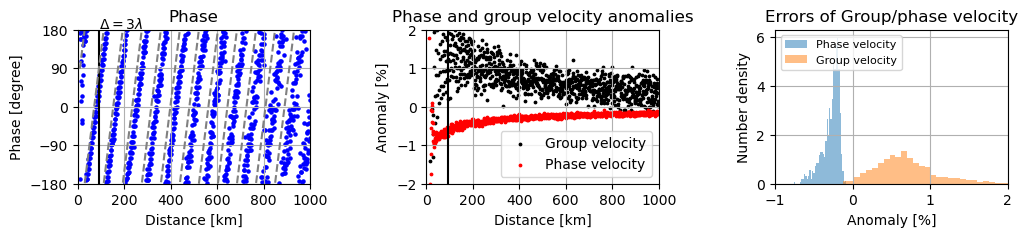

In [100]:
dcp_ary, dcg_ary = [], []
dcp_ary0, dcg_ary0 = [], []
Δ_ary, Φd_ary, Φs_ary = [],[], []

fig, [ax1,ax2,ax4] = plt.subplots(1,3,figsize = (12,2))

f_measure = 0.1 #Measurement at f_measure 
cp_ref = 3.05
    
for Δ in np.arange(10,1000,1):
    α = 40.0*np.sqrt(Δ/200.)
    filt = np.exp(-α*((f_ary-f_measure)/f_measure)**2) #Gaussian filter
    #Signal J0(kΔ), Noise 1%
    sgram = np.fft.irfft((j0(k*Δ)+np.random.randn(len(k))*1E-2)*filt)
    anl = signal.hilbert(sgram) #Analytical signal using Hilbert transform
    env = abs(anl) #Envelope
    Φ = np.angle(anl) 
    Φu = np.unwrap(Φ)
    τg = np.argmax(env[0:length//2]) #Group travel time [s]

    ω_mod = (Φu[τg+1]-Φu[τg-1])/(2.*Δt) #The frquency is corrected using the instateneous frequency
    cp_true, cg_true = cal_disp(ω_mod/2/np.pi) #The true value of phase/group velocities
    cg_measure = Δ/τg #Group velocity measurement

    #Choose phase velocity measurements at around f_measure
    Φs2 = -f_measure*2*np.pi*Δ*(1/cp_ref-1/cal_disp(f_measure)[1])+np.pi/4 #For the plot of the reference
    Φs = -ω_mod*Δ*(1/cp_ref-1/cg_measure)+np.pi/4 # A reference for phase velocity measurement
    dΦ = np.angle(anl[τg]/np.exp(1j*(Φs))) #Phase difference
    kobs = -dΦ/Δ+ω_mod/cp_ref
    cp_obs = ω_mod/kobs
        
    Δ_ary.append(Δ)
    Φd_ary.append(np.rad2deg(Φ[τg]))
    Φs_ary.append(np.angle(np.exp(1j*(Φs2)),deg=True))
    dcp_ary0.append((cp_obs-cp_true)/cp_true*1E2)
    dcg_ary0.append((Δ/τg-cg_true)/cg_true*1E2)

    if Δ > 3*cp_true/f_measure  and abs(cp_obs-cp_true)/cp_true*1E2 <3 and abs(Δ/τg-cg_true)/cg_true*1E2 <3:
        dcp_ary.append((cp_obs-cp_true)/cp_true*1E2)
        dcg_ary.append((Δ/τg-cg_true)/cg_true*1E2)
    #else: print("##")

ax1.set_ylim(-180,180)
ax2.set_xlim(0,1000)
ax1.set_yticks(np.arange(-180,270,90))
ax2.set_ylim(-2,2)
ax1.set_xlim(0,1000)

ax4.hist(dcp_ary,bins=40,alpha=0.5,label="Phase velocity",density=True)
ax4.hist(dcg_ary,bins=40,alpha=0.5,label="Group velocity",density=True)

ax1.scatter(Δ_ary,Φd_ary,s=5,color="blue",label="Synthetic data",alpha=1,linewidths=-1)  
ax1.plot([3*cp_ref/freq0,3*cp_ref/freq0],[-180,180],color="k")
ax1.text(3*cp_ref/freq0,183,"$\Delta=3\lambda$")

idx = np.where((Φs_ary[:-1])-np.array(Φs_ary[1:])>0)[0]+1
idx0 = 0
for idx1 in idx:
    ax1.plot(Δ_ary[idx0:idx1],Φs_ary[idx0:idx1],color="gray",linestyle="dashed")
    idx0=idx1
       
ax2.scatter(Δ_ary,dcg_ary0,s=3,color="k",label="Group velocity",alpha=1)
ax2.scatter(Δ_ary,dcp_ary0,s=3,color="red",label="Phase velocity",alpha=1)
ax2.plot([3*cp_ref/freq0,3*cp_ref/freq0],[-10,10],color="k")

for ax in [ax1,ax2]:ax.set_xlabel("Distance [km]")
ax4.set_xlabel("Anomaly [%]")
ax4.set_xlim(-1,2)

ax1.set_ylabel("Phase [degree]")
ax2.set_ylabel("Anomaly [%]")
ax4.set_ylabel("Number density")

plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax1.set_title("Phase")
ax2.set_title("Phase and group velocity anomalies")
ax4.set_title("Errors of Group/phase velocity")

for ax in [ax1,ax2,ax4]:ax.grid()
for ax in [ax2,ax4]:   ax.legend()
ax4.legend(fontsize=8, loc='upper left')
plt.show()

* The left pannel shows the phase difference between the reference (the dashed line) and the data (blue dots).
* The middle panel shows that the measurements generally agree with the true values. The dispersion bias the estimation for a shorter separation distance. When the dispersion is weak, the measurement becomes accurate. Although a narrower bandwidth of the Gaussian filter mitigates the bias, it becomes more susceptible to noise.
* The right panel shows the histogram of the measurement errors. We use data with separation distance $\Delta > 3\lambda$.